# Visible Watermark Detection Prototype

This notebook is a prototype for training a YOLOv8 model using custom data.  More specifically, images that have been watermarked and annotated in Roboflow will be loaded and used in the pipeline.

The custom `RoboflowYOLOv8Loader` is required to load and transform data exported from Roboflow into the format and data structures required to use object detection in Tensorflow and train a YOLOv8 Model.

In [1]:
import os
import math

import keras
import keras_cv
import tensorflow as tf

# project utils
from lib.roboflow_yolov8_loader import RoboflowYOLOv8Loader
import lib.utils as utils

# Also possible to use jax or pytorch.
os.environ["KERAS_BACKEND"] = "tensorflow"

# Objects/Information we are trying to detect.
# numerical representation is based on list index.
CLASS_IDS = [
    "contact",  # contact information
    "identifier",  # image identifier
    "logo",  # a company logo
    "notice",  # copyright or other type of notice
]

DATA_DIR = "./visible-watermark-information-classification-voc2007.v10i.yolov8"

BOUNDING_BOX_FORMAT = "xyxy"
BATCH_SIZE = 4

VALUE_RANGE = (0, 1)

2025-03-22 15:36:22.641755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742672182.658379  115689 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742672182.663796  115689 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 15:36:22.686373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update ju

## Load the visual watermark detection data

The `RoboflowYOLOv8Loader` is then used to load and split the data into different sets required in the pipeline.

In [2]:
# construct custom dataset loader.
data_loader = RoboflowYOLOv8Loader(CLASS_IDS, DATA_DIR, batch_size=BATCH_SIZE)

# load dataset.
# split percentage is managed by Roboflow and exported.
train, val, test = data_loader.load_dataset()

# verify split percentage from Roboflow
utils.view_splits(train, val, test)

100%|██████████| 1050/1050 [00:00<00:00, 20592.52it/s]
I0000 00:00:1742672188.356215  115689 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6061 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
100%|██████████| 50/50 [00:00<00:00, 21284.40it/s]

         Dataset Splits          
   Split  Percentage
0  train       87.50
1    val        8.33
2   test        4.17


## Visualize the training data

The annotated training data is visualized below to verify that the custom loader has loaded and transformed the data, and that the bounding boxes are in the correct format and are accurate.  This is critical to ensuring the object detector has accurate data when training.  The validation data is also visualized to ensure that it is correct as well.  If the validation data was incorrect then model tuning would not work well because the metrics used to tune the model during training would be incorrect.

The Keras object detection pipeline requires the dataset to be in a specific format.  When loading the dataset, we used the following structure:

```python
{
    "images": Tensor(),
    "bounding_boxes": {
        "classes": Tensor(),
        "boxes": RaggedTensor()
    }
}
```

The bounding box format needs to be translated from a python dictionary to dense bounding box tensors and this is done using the dataset `map` function.

```python
{
    "images": Tensor(),
    "bounding_boxes": DenseTensor()
}
```

In [3]:
augmenters = [
    keras_cv.layers.RandomSaturation(factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomContrast(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomHue(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640),
        scale_factor=(0.9, 1.1),
        bounding_box_format=BOUNDING_BOX_FORMAT
    )
]   

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)


resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format=BOUNDING_BOX_FORMAT, pad_to_aspect_ratio=True
)

def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=30
    )

TRAINING_SET_SIZE = len(train) # get total value before augmentation and batching
STEPS_PER_EPOCH = math.floor(TRAINING_SET_SIZE / BATCH_SIZE)
NUM_EPOCHS = 150

# load into correct format for the model
train_ds = ( train
                .shuffle(BATCH_SIZE * len(CLASS_IDS))
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

val_ds =   ( val
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

test_ds =  ( test
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

TRAINING DATA


2025-03-22 15:36:32.829378: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node random_hue_1/stateful_uniform/RngReadAndSkip/_6}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-03-22 15:36:32.829483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3253406991802400904
2025-03-22 15:36:32.829516: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16620714871768874448
2025-03-22 15:36:32.829541: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node random_hue_1/stateful_uniform/RngReadAndSkip/_6}}]]
	 [[random_hue_1/stateful_uniform/Cast_1/_2]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-03-22 15:36:32.829567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cance

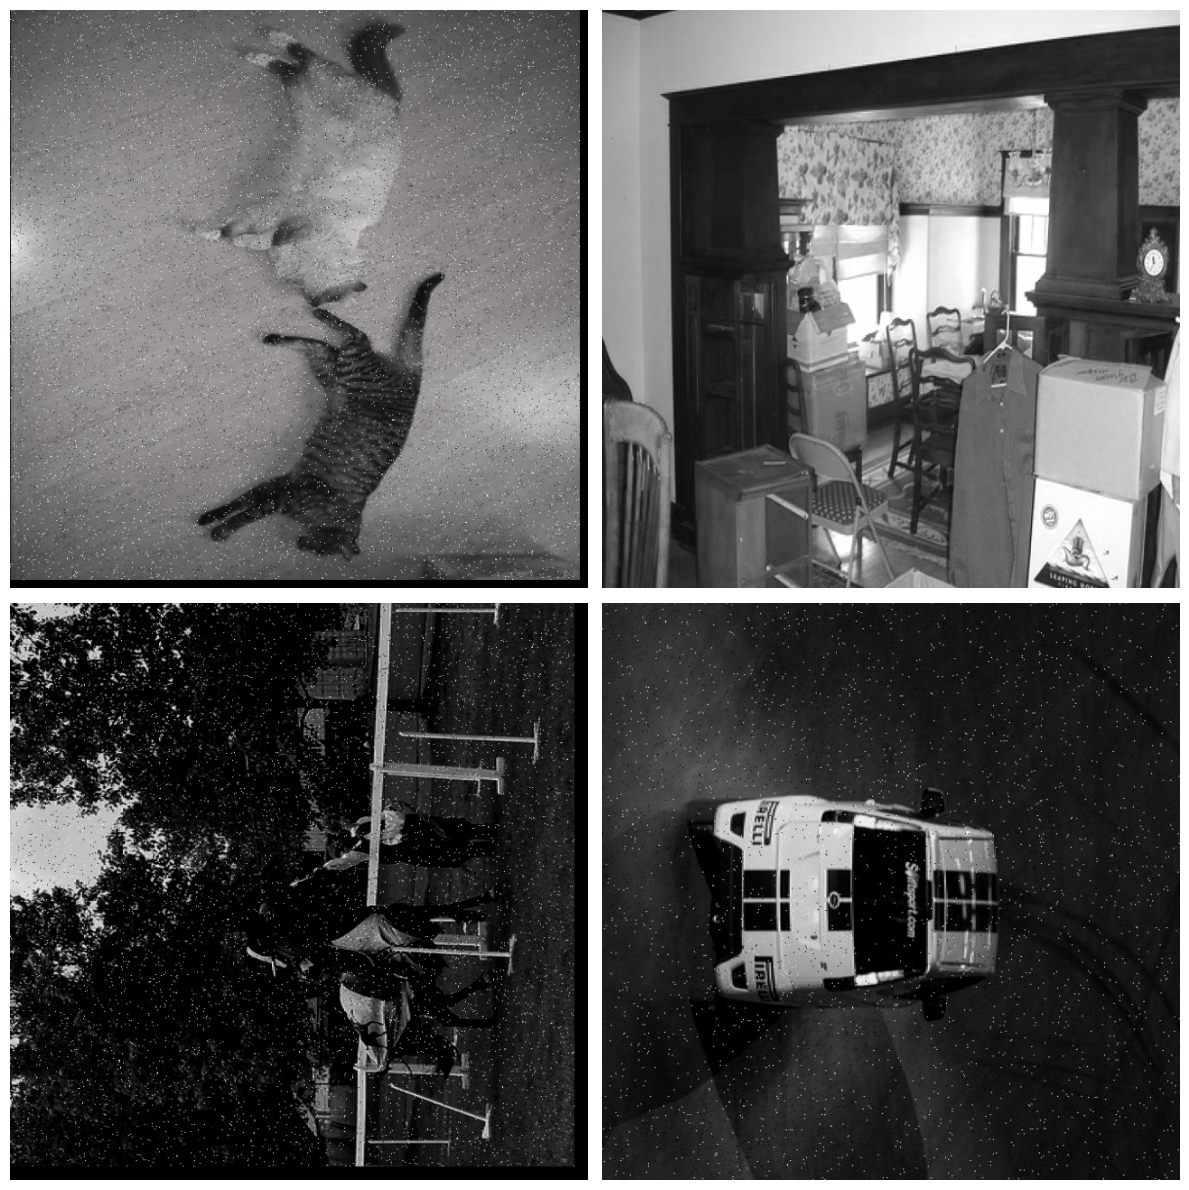

In [4]:
# visualize the training split.
print("TRAINING DATA")
utils.visualize_dataset(
    train_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT, 
    rows=2, cols=2, 
)

VALIDATION DATA


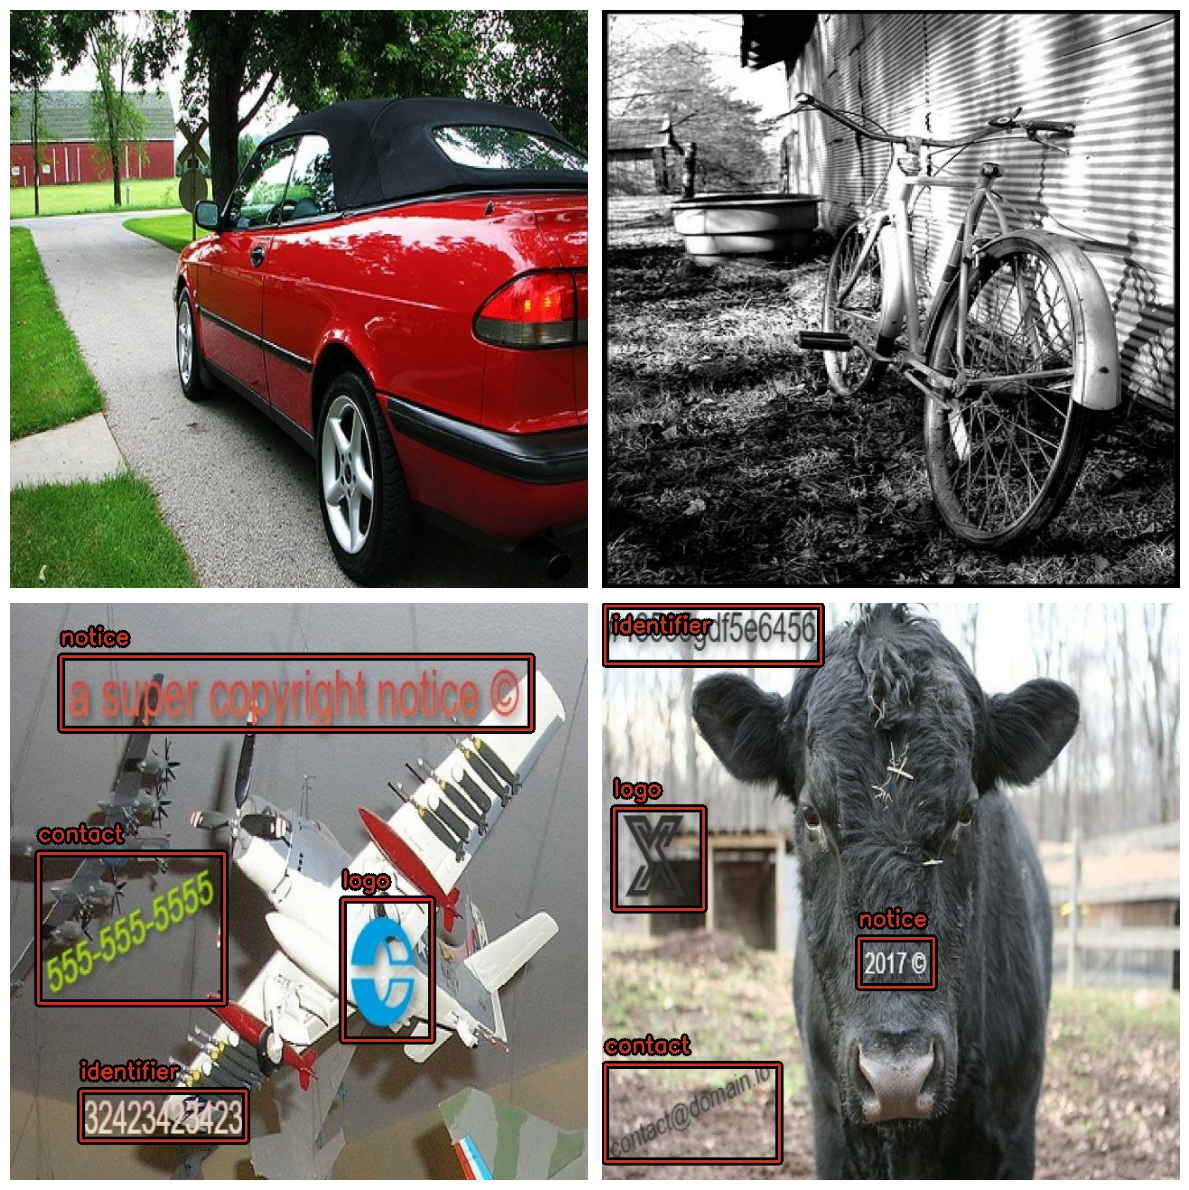

In [5]:
print("VALIDATION DATA")
utils.visualize_dataset(
    val_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    rows=2,
    cols=2,
)

In [6]:
# small dataset requires small model otherwise we risk overfitting.
# load weights of backbone so that it can then be fine-tuned to the dataset.

backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco", load_weights=True
)

model = keras_cv.models.YOLOV8Detector(
    num_classes=len(CLASS_IDS),
    bounding_box_format=BOUNDING_BOX_FORMAT,
    backbone=backbone,
    # fpn_depth=3,
)

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=math.floor(STEPS_PER_EPOCH * NUM_EPOCHS),
    alpha=0.0,
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, global_clipnorm = 10.0)

model.compile(
    classification_loss="binary_crossentropy",
    box_loss=keras_cv.losses.CIoULoss(bounding_box_format=BOUNDING_BOX_FORMAT),
    optimizer=optimizer,
)

## Train the YOLOv8 model using custom watermark dataset

The code below leverages functions available in the Keras computer vision library to help visualize model predictions so that they can be evaluated visually after each epoch.  This helps to understand the progress and give a visual representation of the mapping between detections and COCO metrics used when training the model.

Note: The model doesn't show very good accuracy at this stage, and doesn't have to.  With the successful training of the model, we can validate that the entire workflow (watermarking, annotation, loading and processing) works to format the data as required to train the model.

In [7]:
class VisualizeDetections(keras.callbacks.Callback):
    """Used to visualize detection progress after each epoch.
    Reference: https://keras.io/examples/vision/yolov8/
    """
    def on_epoch_end(self, epoch, logs):
        utils.visualize_detections(
            self.model,
            bounding_box_format=BOUNDING_BOX_FORMAT,
            dataset=val_ds,
            class_mapping=data_loader.class_mapping,
        )

# Train the YOLOv8 model using custom watermark image dataset.
model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH, # matches decay_steps for regularization
    epochs=NUM_EPOCHS,  # early stopping callback may mean this is never reached.
    callbacks=[
        # Tuning the model based on metrics from this callback has been very inconsistent. 
        # This is left here for demonstration purposes, but should be replaced.
        # Github issues:
        #   - https://github.com/keras-team/keras-cv/issues/2402
        #   - https://github.com/keras-team/keras-cv/issues/2442
        keras_cv.callbacks.PyCOCOCallback(  # COCO metrics (AP/AR @ IOU)
            val_ds,
            bounding_box_format=BOUNDING_BOX_FORMAT,
        ),
        keras.callbacks.TensorBoard(  # training progress visualization
            log_dir="training_logs"
        ),
        keras.callbacks.ModelCheckpoint(
            filepath="./model/best_model.keras",
            monitor="val_loss",     # using combination of class/box loss since PyCOCOCallback unreliable.
            save_best_only=True,  # Only keep the best model
            verbose=1,
        ),
        keras.callbacks.EarlyStopping(
            patience=7,
            monitor="val_loss", # using combination of class/box loss since PyCOCOCallback unreliable.
            verbose=1,
            restore_best_weights=True,  # Restore weights of the best epoch
        ),
        # VisualizeDetections(),  # visual validation after each epoch
    ],
    # verbose=0,  # suppress epoch output since monitoring in TensorBoard.
)

Epoch 1/150


/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)
I0000 00:00:1742672233.288934  115782 service.cc:148] XLA service 0x7fea14014070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742672233.289002  115782 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2025-03-22 15:37:14.951734: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742672238.377736  115782 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-22 15:37:21.780369: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.30GiB with freed

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/steptep - box_loss: 1.0708e-04 - class_loss: 1204.0634 - lo
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1

2025-03-22 15:41:08.404584: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


262/262 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - box_loss: 1.0038e-04 - class_loss: 23.9062 - loss: 23.9063 - val_box_loss: 9.5611e-05 - val_class_loss: 3.1481 - val_loss: 3.1482 - val_AP: -1.0000 - val_AP50: -1.0000 - val_AP75: -1.0000 - val_APs: -1.0000 - val_APm: -1.0000 - val_APl: -1.0000 - val_ARmax1: -1.0000 - val_ARmax10: -1.0000 - val_ARmax100: -1.0000 - val_ARs: -1.0000 - val_ARm: -1.0000 - val_ARl: -1.0000
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/steptep - box_loss: 9.0293e-05 - class_loss: 10.6546 - 
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Pre

2025-03-22 15:46:09.309730: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 536870912 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1742672769.309840  115780 device_host_allocator.h:61] could not allocate pinned host memory of size: 536870912
2025-03-22 15:46:09.471914: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 483183872 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1742672769.472294  115780 device_host_allocator.h:61] could not allocate pinned host memory of size: 483183872
2025-03-22 15:46:09.604824: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 434865664 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1742672769.604881  115780 device_host_allocator.h:61] could not allocate pinned host memory of size: 434865664
2025-03-22 15:46:09.679657: E externa

  6/262 ━━━━━━━━━━━━━━━━━━━━ 3:03 717ms/step - box_loss: 3.1100e-05 - class_loss: 8.6819 - loss: 8.6820

2025-03-22 15:46:11.277112: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 58745088 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1742672771.277163  115780 device_host_allocator.h:61] could not allocate pinned host memory of size: 58745088


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step ep - box_loss: 6.9617e-05 - class_loss: 1.5491 
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.030
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 

2025-03-22 15:51:03.273548: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

## Final visualization on test data

After the model has been fine-tuned with the custom training and validation data, it is essential to evaluate the models ability to generalize to unseen data.  To do this we need to use the test set, since it was not used during the training process. (Simple hold off.)

This method may be evolved as-needed throughout the project to improve the accuracy of the detector.

/home/gb/vwic/keras_cv/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


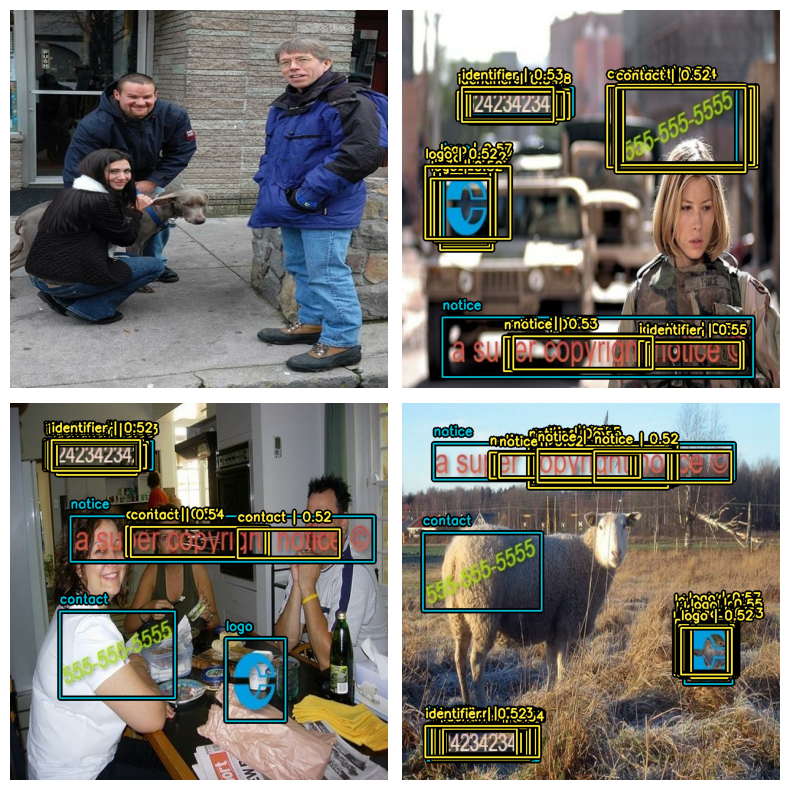

evaluating...:   0%|          | 0/12 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


evaluating...:   8%|▊         | 1/12 [00:00<00:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


evaluating...:  17%|█▋        | 2/12 [00:00<00:02,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


evaluating...:  25%|██▌       | 3/12 [00:00<00:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


evaluating...:  33%|███▎      | 4/12 [00:00<00:01,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


evaluating...:  42%|████▏     | 5/12 [00:01<00:01,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


evaluating...:  50%|█████     | 6/12 [00:01<00:01,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


evaluating...:  58%|█████▊    | 7/12 [00:01<00:00,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


evaluating...:  67%|██████▋   | 8/12 [00:01<00:00,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


evaluating...:  75%|███████▌  | 9/12 [00:01<00:00,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


evaluating...:  83%|████████▎ | 10/12 [00:01<00:00,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


evaluating...:  92%|█████████▏| 11/12 [00:01<00:00,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


evaluating...: 100%|██████████| 12/12 [00:02<00:00,  5.65it/s]


         COCO Metrics            
                         Metric     Value
0                           MaP  0.190468
1                  MaP@[IoU=50]  0.360056
2                  MaP@[IoU=75]  0.173670
3              MaP@[area=small]  0.000000
4             MaP@[area=medium]  0.280163
5              MaP@[area=large]  0.174201
6     Recall@[max_detections=1]  0.360870
7    Recall@[max_detections=10]  0.479891
8   Recall@[max_detections=100]  0.483696
9           Recall@[area=small]  0.000000
10         Recall@[area=medium]  0.524433
11          Recall@[area=large]  0.395245


In [13]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=BOUNDING_BOX_FORMAT,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.52,
)

utils.visualize_detections(
    model,
    dataset=test_ds,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    class_mapping=data_loader.class_mapping,
)

utils.evaluate_coco_metrics(model, test_ds, BOUNDING_BOX_FORMAT)


# References

[1] Team, Keras. “Keras Documentation: Efficient Object Detection with YOLOV8 and KerasCV.” Keras.io, keras.io/examples/vision/yolov8/.


[2] K. Team, “Keras documentation: Keras API reference,” keras.io. https://keras.io/api/
‌